In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
path = 'data/'

apps = pd.read_csv(f'{path}applications.csv')
sellers = pd.read_csv(f'{path}seller.csv')
categories = pd.read_csv(f'{path}product_category.csv')
status = pd.read_csv(f'{path}application_status.csv')
v_types = pd.read_csv(f'{path}vehicle_type.csv')
compat = pd.read_csv(f'{path}compatibility.csv')
vehicles = pd.read_csv(f'{path}vehicles.csv')

# --- STEP 1: Merge static lookup tables into Applications ---
df = apps.merge(sellers, left_on='seller_id', right_on='id', how='left', suffixes=('', '_seller'))
df = df.merge(categories, left_on='category_id', right_on='id', how='left', suffixes=('', '_cat'))
df = df.merge(status, left_on='status_id', right_on='id', how='left', suffixes=('', '_status'))
df = df.merge(v_types, left_on='vehicle_type_id', right_on='id', how='left', suffixes=('', '_vtype'))

# Clean up redundant ID columns from merges
cols_to_drop = [c for c in df.columns if c.endswith('_id') or c == 'id']
# We keep 'app_id' as our primary key for the next merge

# --- STEP 2: Merge Compatibility and Vehicle Info ---
# Note: One application can be compatible with multiple vehicles (One-to-Many)
vehicle_info = compat.merge(vehicles, left_on='vehicles_id', right_on='id', how='left')

# Final Join: Create the master dataset
# Warning: This will duplicate application rows for every compatible vehicle. 
# For price prediction, you might prefer keeping Step 1 results. 
# For recommendation systems, use Step 2.
final_df = df.merge(vehicle_info, on='app_id', how='left', suffixes=('', '_veh'))

# --- STEP 3: Basic Preprocessing for EDA ---
# Convert dates
final_df['app_register_date'] = pd.to_datetime(final_df['app_register_date'])
final_df['insert_date'] = pd.to_datetime(final_df['insert_date'])

# Preview
print(f"Final dataset shape: {final_df.shape}")
final_df.to_csv('data/auto_parts_master.csv', index=False)


Final dataset shape: (111204, 29)


In [4]:
final_df.head(10)

,app_id,headline,price_gel,price_usd,app_register_date,status_id,category_id,vehicle_type_id,seller_id,item_condition,...,status_name,id_vtype,type_name,bottom_year,top_year,vehicles_id,id_veh,model_name,manufacturer_name,vehicle_type_id_veh
0,10074150,SUZUKI Grand Vitara 1996,25,9,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1996.0,1996.0,1.0,1.0,Grand Vitara,SUZUKI,1.0
1,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1998.0,2022.0,2.0,2.0,Expedition,FORD,1.0
2,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1996.0,2019.0,3.0,3.0,F150,FORD,1.0
3,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1998.0,2021.0,4.0,4.0,Mountaineer,MERCURY,1.0
4,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1998.0,2020.0,5.0,5.0,Navigator,LINCOLN,1.0
5,10101874,MAZDA Mazda 3 / CX-5,35,13,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1975.0,2021.0,6.0,6.0,Mazda 3,MAZDA,1.0
6,10101874,MAZDA Mazda 3 / CX-5,35,13,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1965.0,2022.0,7.0,7.0,CX-5,MAZDA,1.0
7,10107865,MAZDA Protege 1998-2004,100,36,2024-09-18,1,334,1,581148,New,...,standard,1,Car,1998.0,2004.0,8.0,8.0,Protege,MAZDA,1.0
8,10107874,MAZDA MPV / Protege,30,11,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1996.0,2021.0,9.0,9.0,MPV,MAZDA,1.0
9,10107874,MAZDA MPV / Protege,30,11,2024-09-18,1,531,1,581148,New,...,standard,1,Car,1998.0,2023.0,8.0,8.0,Protege,MAZDA,1.0


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111204 entries, 0 to 111203
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   app_id               111204 non-null  int64         
 1   headline             111004 non-null  object        
 2   price_gel            111204 non-null  int64         
 3   price_usd            111204 non-null  int64         
 4   app_register_date    111204 non-null  datetime64[ns]
 5   status_id            111204 non-null  int64         
 6   category_id          111204 non-null  int64         
 7   vehicle_type_id      111204 non-null  int64         
 8   seller_id            111204 non-null  int64         
 9   item_condition       111204 non-null  object        
 10  insert_date          111204 non-null  datetime64[ns]
 11  id                   111204 non-null  int64         
 12  seller_name          111204 non-null  object        
 13  address       

#### EDA Analysis

### 1. Compatibility EDA: The "Versatility" Factor
Compatibility modeling often starts with understanding how "universal" a part is. A part that fits 10 different car models is fundamentally different from a bespoke part.

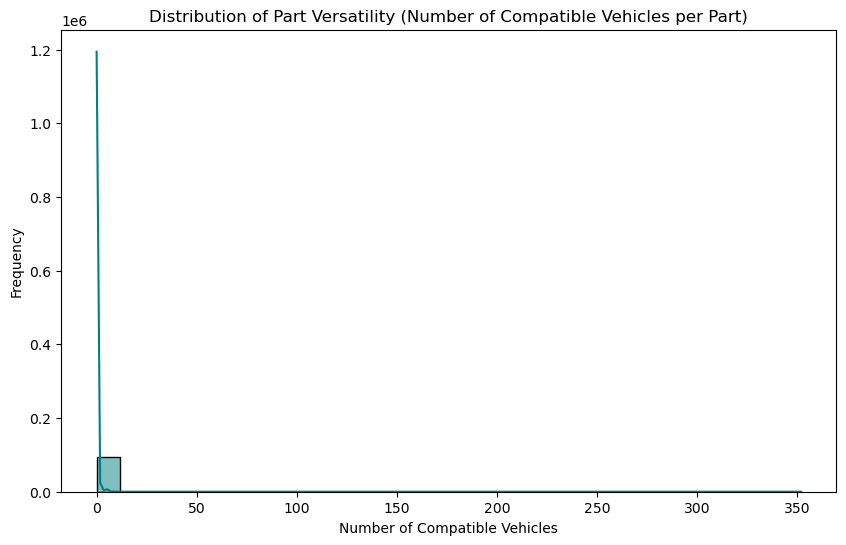

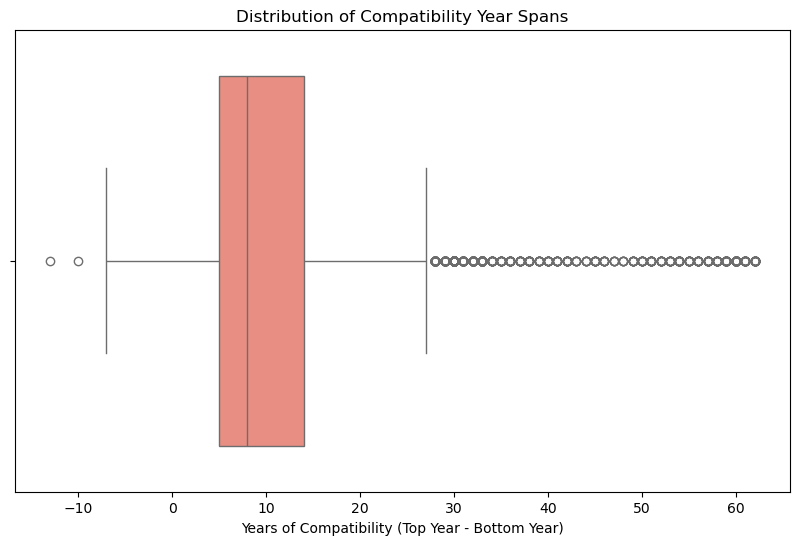

In [8]:
# 1. Calculate Versatility (How many unique vehicles each part fits)
versatility = compat.groupby('app_id')['vehicles_id'].nunique().reset_index()
versatility.columns = ['app_id', 'vehicle_count']

# Merge versatility back to the main applications data
apps_with_versatility = apps.merge(versatility, on='app_id', how='left')
apps_with_versatility['vehicle_count'] = apps_with_versatility['vehicle_count'].fillna(0)

# Visualization: Distribution of Part Versatility
plt.figure(figsize=(10, 6))
sns.histplot(apps_with_versatility['vehicle_count'], bins=30, kde=True, color='teal')
plt.title('Distribution of Part Versatility (Number of Compatible Vehicles per Part)')
plt.xlabel('Number of Compatible Vehicles')
plt.ylabel('Frequency')
plt.savefig('images/versatility_distribution.png')
plt.show()

# 2. Year Span Analysis (How long is a part compatible?)
compat['year_span'] = compat['top_year'] - compat['bottom_year']

plt.figure(figsize=(10, 6))
sns.boxplot(x='year_span', data=compat, color='salmon')
plt.title('Distribution of Compatibility Year Spans')
plt.xlabel('Years of Compatibility (Top Year - Bottom Year)')
plt.savefig('images/year_span_boxplot.png')
plt.show()

### 2. Cross-Manufacturer Compatibility
Do certain categories of parts (e.g., "Engine" vs "Brakes") tend to fit multiple manufacturers? This is a key insight for supply chain and recommendation systems.

In [9]:
# Merge Category names into the compatibility data
compat_full = (compat
               .merge(apps[['app_id', 'category_id']], on='app_id')
               .merge(categories[['id', 'category_name']], left_on='category_id', right_on='id')
               .merge(vehicles[['id', 'manufacturer_name']], left_on='vehicles_id', right_on='id'))

# Count unique manufacturers per application
manuf_versatility = compat_full.groupby('app_id')['manufacturer_name'].nunique().reset_index()
manuf_versatility.columns = ['app_id', 'manufacturer_count']

# See which categories are most "Universal" (Cross-Brand)
universal_cats = (compat_full.groupby('category_name')['manufacturer_name']
                  .nunique()
                  .sort_values(ascending=False))

print("Most Universal Categories (Fitting multiple Brands):")
print(universal_cats.head(10))

Most Universal Categories (Fitting multiple Brands):
category_name
Water radiator                 47
Brake Shoe Set                 46
Shock Absorber                 45
Front windshield               42
Water Pump, engine cooling     42
Headlight                      41
Control Arm                    41
Condenser, air conditioning    40
Hood                           39
Wheel Hub                      39
Name: manufacturer_name, dtype: int64


### Generate a "Compatibility" dataset for Machine Learning

In [13]:
# 1. Positive Samples: Existing links in compatibility.csv
positives = compat[['app_id', 'vehicles_id']].copy()
positives['fits'] = 1

def generate_negatives(pos_df, apps_df, vehicles_df, multiplier=1):
    neg_samples = []
    all_apps = apps_df['app_id'].values
    all_vehs = vehicles_df['id'].values
    existing_pairs = set(zip(pos_df['app_id'], pos_df['vehicles_id']))
    
    while len(neg_samples) < len(pos_df) * multiplier:
        a = np.random.choice(all_apps)
        v = np.random.choice(all_vehs)
        if (a, v) not in existing_pairs:
            neg_samples.append([a, v, 0])
            
    return pd.DataFrame(neg_samples, columns=['app_id', 'vehicles_id', 'fits'])

negatives = generate_negatives(positives, apps, vehicles)
ml_data = pd.concat([positives, negatives]).sample(frac=1).reset_index(drop=True)

# Save for Modeling
ml_data.to_csv('data/compatibility_training_set.csv', index=False)

In [12]:
ml_data.head(10)

,app_id,vehicles_id,fits
0,12337509,416,0
1,11544254,49,1
2,11774927,957,1
3,11688048,166,1
4,12422146,6,0
5,12068949,815,0
6,12463391,566,0
7,11820775,34,1
8,12545913,324,0
9,12325771,1305,0


### Baseline Numbers for Compatibility

#### 1. The "Network Density" Baseline

In [15]:
# Assuming 'compat' is your compatibility dataframe
total_possible_links = apps['app_id'].nunique() * vehicles['id'].nunique()
actual_links = len(compat)
density = (actual_links / total_possible_links) * 100

print(f"Network Density: {density:.6f}%")

Network Density: 0.020046%


#### 2. Vehicle-Side Baseline (The "Parts per Car" Metric)
 How many parts are available for each vehicle. 

In [17]:
# Number of parts available per vehicle
parts_per_vehicle = compat.groupby('vehicles_id').size()

print("Vehicle Baseline:")
print(parts_per_vehicle.describe())

# Identifying Data-Poor Vehicles
low_data_vehs = (parts_per_vehicle < 5).sum()
print(f"Vehicles with fewer than 5 parts: {low_data_vehs} ({low_data_vehs/len(vehicles)*100:.1f}%)")

Vehicle Baseline:
count    1611.000000
mean       19.197393
std        42.673244
min         1.000000
25%         2.000000
50%         7.000000
75%        19.000000
max       882.000000
dtype: float64
Vehicles with fewer than 5 parts: 651 (40.3%)


#### 3. Chronological Baseline (The "Compatibility Window")
How far back or forward a part usually goes ?

In [19]:
# Calculate the year range for every compatibility link
compat['year_range'] = compat['top_year'] - compat['bottom_year']

print("Year Span Baseline:")
print(compat['year_range'].describe())

# Baseline: What is the 'typical' window?
q90 = compat['year_range'].quantile(0.90)
print(f"90% of parts cover a span of {q90} years or less.")

Year Span Baseline:
count    30927.000000
mean        10.647298
std          8.849450
min        -13.000000
25%          5.000000
50%          8.000000
75%         14.000000
max         62.000000
Name: year_range, dtype: float64
90% of parts cover a span of 23.0 years or less.


#### 4. Categorical Baseline (The "Cross-Fit" Table)
Which part categories are more compatible than others.

In [20]:
# Group by category and find the average number of vehicles a part fits
cat_baseline = (compat.merge(apps[['app_id', 'category_id']], on='app_id')
                .merge(categories[['id', 'category_name']], left_on='category_id', right_on='id')
                .groupby('category_name')
                .agg(avg_fitment=('vehicles_id', 'count'), 
                     unique_parts=('app_id', 'nunique')))

cat_baseline['fits_per_part'] = cat_baseline['avg_fitment'] / cat_baseline['unique_parts']
print(cat_baseline.sort_values('fits_per_part', ascending=False).head(10))

                             avg_fitment  unique_parts  fits_per_part
category_name                                                        
Hydraulic radiator                    63             1      63.000000
Handbrake                            292             7      41.714286
Steering Wheel Spiral Cable          571            16      35.687500
MAP sensor                            30             1      30.000000
Outer belt                            22             1      22.000000
Tire bluetooth sensor                120             6      20.000000
Diaphragm                             55             3      18.333333
Distronic                             36             2      18.000000
Engine gasket                         99             6      16.500000
Detonation sensor                     44             4      11.000000


In [21]:
def generate_compatibility_baselines(apps, compat, vehicles, categories):
    baselines = {}
    
    # 1. Network Connectivity Baseline
    total_parts = apps['app_id'].nunique()
    total_vehs = vehicles['id'].nunique()
    actual_links = len(compat)
    
    baselines['Global'] = {
        'Total Possible Links': total_parts * total_vehs,
        'Actual Links': actual_links,
        'Fill Rate (%)': (actual_links / (total_parts * total_vehs)) * 100
    }

    # 2. Part Versatility (The "Supply" Side)
    # How many vehicles does each part typically fit?
    part_counts = compat.groupby('app_id')['vehicles_id'].count()
    baselines['Part Versatility'] = {
        'Median Fits per Part': part_counts.median(),
        'Mean Fits per Part': part_counts.mean(),
        'Max Fits (Universal Part)': part_counts.max(),
        'Percentage of Single-Fit Parts': (part_counts == 1).sum() / total_parts * 100
    }

    # 3. Vehicle Coverage (The "Demand" Side)
    # How many parts are available for each unique car?
    veh_counts = compat.groupby('vehicles_id')['app_id'].count()
    baselines['Vehicle Coverage'] = {
        'Median Parts per Vehicle': veh_counts.median(),
        'Vehicles with Zero Parts': total_vehs - len(veh_counts),
        'Top 10% Most Supported Vehicles (Part Count)': veh_counts.quantile(0.9)
    }

    # 4. Temporal Baseline (The "Age" Factor)
    # How broad is the compatibility window?
    compat['year_span'] = compat['top_year'] - compat['bottom_year']
    baselines['Temporal Window'] = {
        'Avg Year Span': compat['year_span'].mean(),
        '90th Percentile Span': compat['year_span'].quantile(0.9),
        'Negative Spans (Data Errors)': (compat['year_span'] < 0).sum()
    }
    
    return baselines

# Execute
base_stats = generate_compatibility_baselines(apps, compat, vehicles, categories)

# Displaying in a readable format
for section, metrics in base_stats.items():
    print(f"--- {section} ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")
    print("\n")

--- Global ---
Total Possible Links: 154279032
Actual Links: 30927
Fill Rate (%): 0.02


--- Part Versatility ---
Median Fits per Part: 1.00
Mean Fits per Part: 2.02
Max Fits (Universal Part): 352
Percentage of Single-Fit Parts: 12.44


--- Vehicle Coverage ---
Median Parts per Vehicle: 7.00
Vehicles with Zero Parts: 3
Top 10% Most Supported Vehicles (Part Count): 48.00


--- Temporal Window ---
Avg Year Span: 10.65
90th Percentile Span: 23.00
Negative Spans (Data Errors): 8




### Visualise Baseline numbers

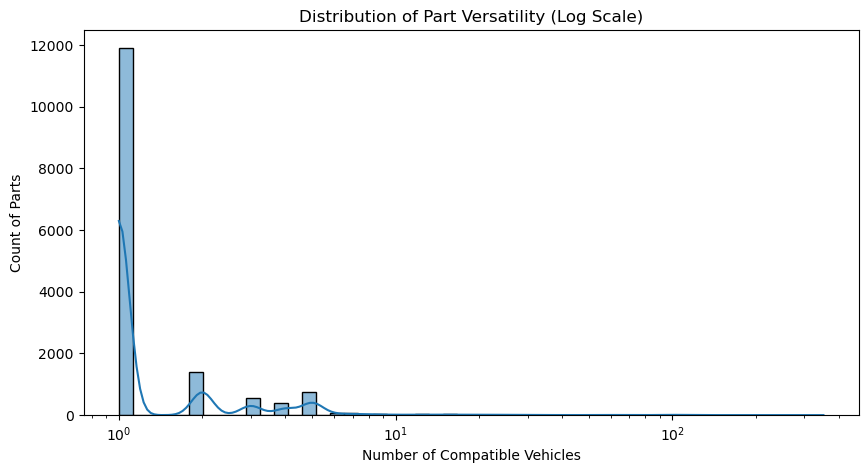

<Figure size 640x480 with 0 Axes>

In [23]:
# Visualizing Part Versatility
plt.figure(figsize=(10, 5))
sns.histplot(compat.groupby('app_id').size(), bins=50, kde=True, log_scale=(True, False))
plt.title('Distribution of Part Versatility (Log Scale)')
plt.xlabel('Number of Compatible Vehicles')
plt.ylabel('Count of Parts')
plt.show()
plt.savefig('images/baselne_numbers.png')

### Manufacturer Cross-Pollination
One last baseline before modeling: How often does a part fit different brands? This is the ultimate test of "Generic" vs "OEM"

In [25]:
# Join compat to vehicles to get brands
brand_map = compat.merge(vehicles[['id', 'manufacturer_name']], left_on='vehicles_id', right_on='id')
brand_counts = brand_map.groupby('app_id')['manufacturer_name'].nunique()

print(f"Percentage of parts that fit multiple brands: {(brand_counts > 1).mean() * 100:.2f}%")

Percentage of parts that fit multiple brands: 6.05%
